# Introduction
Many Natural Processing models and alorithms are defined to work on texts that have undergone some pre-processing.
Typical pre-processing steps are:
1. Tokenising the text.
    1. Splitting the text into separate units for each word.
    2. Grouping these tokens in separate sentences.
3. Part of Speech tagging the words, i.e. labeling them as Noun, Verb, etc.
4. Parsing word dependencies in each sentence, building a graph depicting the relationship of words within a sentence.

Other typical pre-processing steps are stemming and lemmatization. Both methods aim to reduce word tokens to their base form, for example `achieved` might be converted to `achieve`. 
The difference between stemming and lemmatization is that stemming typically uses some heuristic to cut of the end of words, and the resulting tokens might not be real words.
Lemmatization on the other hand uses vocabularies and linguistic analysis to turn the word into its base form, its `lemma`.

Many wordbanks are structured using the [CoNLL-U](http://universaldependencies.org/format.html) format, which includes POS-tags, word dependencies, lemma/stem etc. 
Being able to convert unstructured text data CoNLL-U is very useful if you want to apply a method expecting CoNLL-U format on your own unstructured text data.

In this notebook I aim to create a Part of Speech (POS) tagger for word- and sentence-tokenised text.
To train and evaluate my model I will be using text data already in CoNLL-U format, which means I do not need to apply any tokenisation myself. 

In early 2017 I took a course in Natrual Language Processing at Linköping University where me and my lab partner got to implement both a Part of Speech tagger and an unlabeled dependency parser (a dependency parser that does not put names on the relationships in a sentence). 
We used a single layer perceptron as classifier for both the Part of Speech tagger and the Dependency Parser.
This time around I will explore some other possibilities!

# The data
For me it would be nice to compare my results me and my lab partner got last time around, so I will opt to use the same training and test data:
[Universal Dependencies - English Web Treebank](http://universaldependencies.org/treebanks/en_ewt/index.html), a CoNLL-U formart corpus with 254 830 words and 16 622 sentences in english *taken from various web media including weblogs, newsgroups, emails, reviews, and Yahoo! answers*.

## Load the Data
First lets load the training data and convert it to a python dictionary and a pandas data frame.
I use the [conllu](https://github.com/EmilStenstrom/conllu) python package to parse the CoNLL-U files to dictionaries.

In [1]:
import conllu

Read the traing data.

In [16]:
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-train.conllu'.format(directory), 'r', encoding='utf-8') as f:
    train_text = f.read()

Convert it to a dictionary.

In [43]:
train_dict = conllu.parse(train_text)

Count sentences and tokens.

In [26]:
from functools import reduce

n_train_sentences = len(train_dict)
n_train_tokens = reduce(lambda x, y: x + len(y), train_dict, 0)

print("The training set contains {} sentences and {} tokens".format(n_train_sentences, n_train_tokens))

The training set contains 12543 sentences and 204607 tokens


Store the data in a Pandas DataFrame for easier analysis.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [44]:
def conllu_dict_to_dataframe(conllu_dict):
    # Assign a sentence id to each token
    for i, sentence in enumerate(conllu_dict):
        for token in sentence:
            token['sentence_id'] = i
    flattened_dict = reduce(lambda x, y: x + y, conllu_dict)
    return pd.DataFrame(flattened_dict)

In [45]:
training_df = conllu_dict_to_dataframe(train_dict)

## Explore the Data
My goal with this task is not to create a POS-tagger that does a perfect job for this exact data, so I won't spend to much time exploring the specifics of the data set. But it is interesting to at least get a feel for its contents.

I will be POS-tagging tokens with the rest of their sentence available, this means that the data I am interested in is:
* `form`, the token being tagged.
* `upostag`, the target label.
* Words with the same sentence_id, and their positions in relation to the word being classified. I will not have access to deps.

I could possibly also apply stemming or lemmatization to sentences before POS-tagging, of course converting a token to its base form could give it a new correct POS-tag, so I would only use the lemma as a complementary feature.
However, I will ignore lemma for now but possibly add it in a later stage.

In [49]:
training_df.head()

,id,form,lemma,upostag,xpostag,feats,head,deprel,deps,misc,sentence_id
0,1.0,Al,Al,PROPN,NNP,{'Number': 'Sing'},0.0,root,"[(root, 0)]",{'SpaceAfter': 'No'},0
1,2.0,-,-,PUNCT,HYPH,None,1.0,punct,"[(punct, 1)]",{'SpaceAfter': 'No'},0
2,3.0,Zaman,Zaman,PROPN,NNP,{'Number': 'Sing'},1.0,flat,"[(flat, 1)]",None,0
3,4.0,:,:,PUNCT,:,None,1.0,punct,"[(punct, 1)]",None,0
4,5.0,American,american,ADJ,JJ,{'Degree': 'Pos'},6.0,amod,"[(amod, 6)]",None,0


### Unique tokens

In [50]:
training_df['form'].nunique()

19672

### Most common tokens

In [51]:
training_df['form'].value_counts()[:10]

.      8640
the    8152
,      7021
to     5076
and    4855
a      3609
of     3589
I      3122
in     2911
is     2153
Name: form, dtype: int64

### Token frequencies
I bet there are many tokens that appear very few times, perhaps just 1. Lets get a feel for how the frequencies of each token is distributed.

In [54]:
import numpy as np

In [58]:
low_freqs = np.arange(1, 21, 1)

In [59]:
val_counts = training_df['form'].value_counts()

In [77]:
occurrences = [100 * (val_counts >= i).sum() / val_counts.count() for i in low_freqs]

(1, 20)

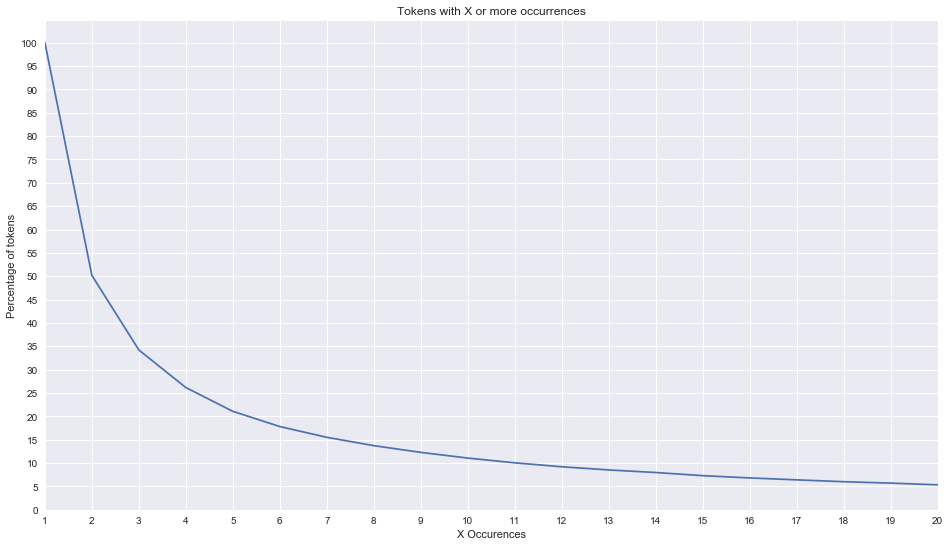

In [81]:
f, ax = plt.subplots(figsize=(16, 9))
plt.plot(low_freqs, occurrences)
ax.xaxis.set_ticks(low_freqs);
ax.yaxis.set_ticks(np.arange(0, 101, 5));
ax.set_ylabel('Percentage of tokens')
ax.set_xlabel('X Occurences')
ax.set_title('Tokens with X or more occurrences')
ax.set_xlim([1, 20])

About 20% of tokens in the training set occur 5 or more times, only 5% appear 20 or more times. 50% of tokens only appear one time.

How I handel the sparsity of the data could have a large impact on my models performance and especially on runtime and memory efficiency.

### Part of Speech Tags

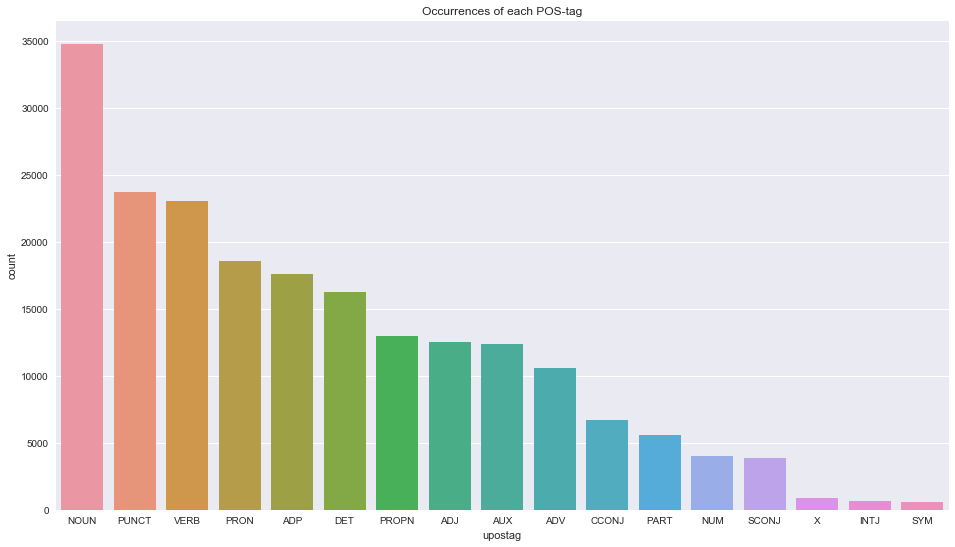

In [86]:
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x='upostag', data = training_df, order=training_df['upostag'].value_counts().index, ax=ax)
ax.set_title("Occurrences of each POS-tag")

### Sentence length

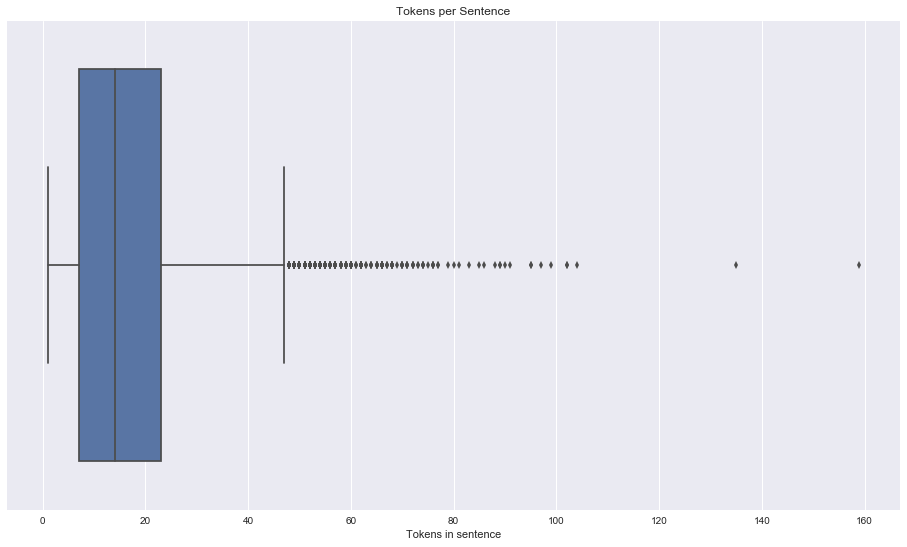

In [95]:
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(training_df.groupby('sentence_id').agg({'form' : 'count'}), ax=ax)
ax.set_xlabel('Tokens in sentence')
ax.set_title('Tokens per Sentence')

Most sentences are shorter than ~25 words, but there exists some extreme cases.

# Feature Engineering
As I have some previous experience with POS-tagging I will not spend to much time investigating new features.
Rather, I will opt to use features that I already know work well.

Worth to note is that I will POS tag the words sequentially. I.E. I start with the first word, estimate its POS-tag, and then move on to the next word without ever reconsidering the first words POS-tag.

List of features:
* The word itself
* The probabilities that the word belong to each label based on Maximum Likelihood Estimation on the training data using only the word it seld as a feature, this will be fetched from a predefined dictionary. (One entry per label)
* The word left of the word in the sentence
* The word right of the word in the sentence 
* The POS-tag of the left word in the sentence (One-hot encoded)
* Token length, normalised (float)
* Suffix, last two characters 
* Suffix, last three characters 
* Prefix, first two characters 
* Prefix, first three characters

I need to find a good representation of the categorical features. 
POS-tag of the previous word is obviously fine to one-hot encode, as we don't have to many labels.
Representing individual words, as well as suffixes and prefixes, is a completely different story though.
If I would one-hot encode the words with no dimensionality reduction I would end up with more than 19 000 dimensions per word, and I have three features where I need to represent words.
I would quickly end up with over 60 000 dimensions, most always set to 0.

In my previous implementation the Perceptron classifier was based on Python dictionaries, with entries for each categorical value.
Representing categoricals with dictionaries is a solid way of handeling the sparsity of data, as vector multiplications could be done elementwise very effectively. 
However, such a set up is not compatible with my ML frameworks of choice, `sklearn` and `keras`.

To represent each token I will be using so called word embeddings.
A word embedding is simply a word represented as a vector, so one-hot encoded words fall into this category.
The word embeddings I will use are a little bit more sophisticated though, using fewer dimensions and actually assigning some meaning to the different dimensions.
[Word2vec](https://en.wikipedia.org/wiki/Word2vec) was created by Google, and build word embeddings based on word proximity in training sentences. 
The assumption is that if two different words often appear in the same contexts they are probably similar, and have word embedding that are close to each other. 

The word embedding created by word2vec also have several other interesting properties. For example, consider the vector representation of the word king, G('king'). 
If we subtract G('man') and add G('woman'), we would get a vector very close to the vector G('queen'). 

I am very excited to see what effects this has on my model!

One thing to note here, that I think is very important, is that training a word embedding model does not require POS-tags. 
Had this been the case it would not have made any sense to use it as a pre-processing step for my POS-tagger.
(It is possible to use POS-tags as features for word embeddings, but Googles word2vec implementation only looks at nearby words.)

## Word2Vec
Lets start by converting our tokens into word embeddings.

In [97]:
from gensim.models import Word2Vec

C:\Users\Gustav\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [101]:
train_sentences = [[token['form'] for token in sentence] for sentence in train_dict]

In [138]:
w2v = Word2Vec(train_sentences, min_count=5, size=25)

### Quick demonstration of neat properties

In [139]:
w2v.wv.similar_by_word('king')

[('signs', 0.9950331449508667),
 ('change', 0.9950103163719177),
 ('reply', 0.9943593740463257),
 ('pull', 0.9942187666893005),
 ('guy', 0.9942054152488708),
 ('down', 0.9941377639770508),
 ('kids', 0.9940827488899231),
 ('playing', 0.9940721392631531),
 ('provide', 0.993903398513794),
 ('refer', 0.9938868880271912)]

In [140]:
w2v.wv.similar_by_vector(w2w.wv['king'] - w2w.wv['man'] + w2w.wv['woman'])

[('Otherwise', 0.5614035129547119),
 ('know', 0.5261061191558838),
 ('do', 0.5083385705947876),
 ("n't", 0.4882880449295044),
 ('you', 0.4832954406738281),
 ('want', 0.47248315811157227),
 ('forget', 0.4623956084251404),
 ('if', 0.43421512842178345),
 ('rush', 0.4218112826347351),
 ('I', 0.3984465003013611)]

Ouch, this does not look good at all...
I think my training data is way to small to create valuable word embeddings.
I will try using Google pre trained model instead.
The model can be found [here](https://code.google.com/archive/p/word2vec/), it was pretrained on about 100 billion(!!!) words from the Google News data set.

In [143]:
from gensim.models import KeyedVectors

In [144]:
news_w2v = KeyedVectors.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [145]:
news_w2v.similar_by_word('king')

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204219460487366),
 ('prince', 0.6159993410110474),
 ('sultan', 0.5864823460578918),
 ('ruler', 0.5797567367553711),
 ('princes', 0.5646552443504333),
 ('Prince_Paras', 0.5432944297790527),
 ('throne', 0.5422105193138123)]

In [146]:
news_w2v.similar_by_vector(news_w2v['king'] - news_w2v['man'] + news_w2v['woman'])

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.6454660892486572),
 ('princess', 0.6156250834465027),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.577711820602417),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

In [152]:
news_w2v.similar_by_word('London')

[('EURASIAN_NATURAL_RESOURCES_CORP.', 0.6739697456359863),
 ('Londons', 0.6536128520965576),
 ('Islamabad_Slyvia_Hui', 0.6375559568405151),
 ('Wandsworth', 0.6133824586868286),
 ('Canary_Wharf', 0.6119279861450195),
 ('Battersea', 0.6080656051635742),
 ('Croydon', 0.6077532768249512),
 ('Holborn', 0.5971218347549438),
 ('Ealing', 0.5936053991317749),
 ('Stock_Exchange_LSE_TRIL', 0.5932283401489258)]

In [151]:
news_w2v.similar_by_vector(news_w2v['London'] - news_w2v['England'] + news_w2v['Germany'])

[('Germany', 0.6169734597206116),
 ('Berlin', 0.6122506856918335),
 ('Dusseldorf', 0.6023740768432617),
 ('Frankfurt', 0.5981025695800781),
 ('London', 0.58940589427948),
 ('Düsseldorf', 0.5878291726112366),
 ('Munich', 0.5780648589134216),
 ('Munich_Germany', 0.5410465002059937),
 ('Budapest', 0.5359379053115845),
 ('Duesseldorf', 0.5313573479652405)]

In [153]:
news_w2v.similar_by_word('Germany')

[('Austria', 0.7461062073707581),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868600845337),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437496542930603),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342948079109192)]

The word operations are perhaps not spot on, but it's still damn impressive how London - England + Germany has Berlin as top 2 closest words.